In [27]:
DATASET_DIR = "data/dataset"
from functions.helpers import *
from functions.implementations import *
import numpy as np

print("Loading dataset (could take few minutes)...")
x_train, x_test, y_train, train_ids, test_ids = load_csv_data(DATASET_DIR, sub_sample=False)
print("Dataset Loaded.")

# Extract the columns name (feature name)
feature_name = np.genfromtxt(os.path.join(DATASET_DIR, 'x_train.csv'), delimiter=',', dtype=str, max_rows=1)
feature_name = feature_name[1:] # The "ids" cols have been removed in the load_csv_data() fucntion

Loading dataset (could take few minutes)...
Dataset Loaded.


In [50]:
x_train_copy = x_train.copy()

SEED = 42
SUGGESTED_FEATURE_PATH = "data/suggested_features_dict.json"  # Path to the JSON file containing suggested features
NORMALIZATION_METHOD = "robust_scalar"  # Method to normalize continuous features during preprocessing
    #z-score NOT good if the data is not gaussina
FEATURE_ENGENEERING_TYPE = "all_con"  # Type of feature assembly during feature engineering (see process_data function for details)
THR_VAR_PCA = 0.9  # Percentage of variance to retain during PCA
MAX_NAN_PER_COL = 0.75  # Max percentage of NaNs in one column before removal
DEGREE_POL = 3 # Max degree of feature polinomial expansion (in case is choosen specfiic type of feature engeneering)
SPECIFIC_FEATURES = [
                        'DROCDY3_', 'FRUTDA1_', '_FRUTSUM', '_VEGESUM', 'GRENDAY_', 
                        'METVL11_', 'METVL21_', 'ORNGDAY_', 'PA1MIN_', 'PA1VIGM_', 
                        'PADUR1_', 'PADUR2_', 'PAFREQ1_', 'PAFREQ2_', 'PAMIN11_', 
                        'PAMIN21_', 'PAVIG11_', 'PAVIG21_', 'VEGEDA1_', '_AGE80', 
                        '_BMI5', '_DRNKWEK'
]

In [51]:
import importlib
from functions.training_functions import *
import json

with open(SUGGESTED_FEATURE_PATH, "r") as f:
    suggested_features_dict = json.load(f)

# Prepocess train set
x_train_copy = g(
x_train=x_train_copy,
feature_name=feature_name,  # Features (column names) of the x_train matrix
data_dict=suggested_features_dict,     # Dict where keys are feature names, and values are lists: [nan symbol, feature type ('continuous' or 'discrete')]
thr_nan=MAX_NAN_PER_COL,  # Threshold above which the column will be discarded (default: 75% NaN)
thr_var_pca = THR_VAR_PCA, #Percentage of varaince to save during pca
normalization=NORMALIZATION_METHOD,  # Type of normalization for continuous variables
feature_engeneering_type=FEATURE_ENGENEERING_TYPE,  # Feature engineering option (default: use only continuous variables)
degree_pol = DEGREE_POL, #Max degree of feature polinomial expansion (in case is choosen specfiic type of feature engeneering)
specific_features=SPECIFIC_FEATURES, #Subset of feauture to use, ignoring all the others
)

# Prepocess test set
    #NB same parameters, BUT separated so no leakacge of info
x_test_preprocessed = g(
x_train=x_test,
feature_name=feature_name,  # Features (column names) of the x_train matrix
data_dict=suggested_features_dict,     # Dict where keys are feature names, and values are lists: [nan symbol, feature type ('continuous' or 'discrete')]
thr_nan=MAX_NAN_PER_COL,  # Threshold above which the column will be discarded (default: 75% NaN)
thr_var_pca = THR_VAR_PCA, #Percentage of varaince to save during pca
normalization=NORMALIZATION_METHOD,  # Type of normalization for continuous variables
feature_engeneering_type=FEATURE_ENGENEERING_TYPE,  # Feature engineering option (default: use only continuous variables)
degree_pol = DEGREE_POL, #Max degree of feature polinomial expansion (in case is choosen specfiic type of feature engeneering)
specific_features=SPECIFIC_FEATURES, #Subset of feauture to use, ignoring all the others
) 


print(x_test_preprocessed)


Preprocessing features...
	Creating structured array...
	Selecting features suggested by physicians...
	Filtering columns decided by users...
(328135,)
	Removing columns with too many NaNs...
	Imputing missing values...
		Columns with NaN values: []
0
328135
	Encoding discrete variables...
	Normalizing continuous variables...
	Feature engineering...
	Returning Processed features, shape (328135, 22)...

Preprocessing features...
	Creating structured array...
	Selecting features suggested by physicians...
	Filtering columns decided by users...
(109379,)
	Removing columns with too many NaNs...
	Imputing missing values...
		Columns with NaN values: []
0
109379
	Encoding discrete variables...
	Normalizing continuous variables...
	Feature engineering...
	Returning Processed features, shape (109379, 22)...
[[-0.18737168  1.73138033  0.61428571 ...  0.84615385 -0.81717011
  -0.08841512]
 [ 3.37269029  1.73138033  0.61428571 ... -1.34615385 -0.87599364
   4.52454791]
 [ 0.62457228  1.73138033 

In [46]:
from functions.implementations import *
from numpy.lib import recfunctions as rfn
import matplotlib.pyplot as plt 



class SVM:
    def __init__(self, learning_rate=0.001, lambda_param=0.01, n_iters=1000):
        self.learning_rate = learning_rate   # Learning rate for gradient descent
        self.lambda_param = lambda_param     # Regularization parameter
        self.n_iters = n_iters               # Number of iterations for SGD
        self.w = None                        # Weight vector (will be initialized later)
        self.b = 0                           # Bias term
    
    def fit(self, X, y):
        n_samples, n_features = X.shape

        # Initialize the weight vector to zeros
        self.w = np.zeros(n_features)
        self.b = 0
        
        # Convert the labels to -1 and 1 if they are not in this format
        y_ = np.where(y <= 0, -1, 1)  # Ensures labels are -1 or 1
        
        # Gradient descent (SGD)
        for _ in range(self.n_iters):
            for idx, x_i in enumerate(X):
                # Calculate the condition for hinge loss
                condition = y_[idx] * (np.dot(x_i, self.w) + self.b)
                
                if condition >= 1:
                    # No misclassification, only update w using regularization
                    dw = 2 * self.lambda_param * self.w
                    self.w -= self.learning_rate * dw
                else:
                    # Misclassified sample, update w and b
                    dw = 2 * self.lambda_param * self.w - np.dot(x_i, y_[idx])
                    self.w -= self.learning_rate * dw
                    self.b -= self.learning_rate * y_[idx]

    def predict(self, X):
        # Linear decision boundary: y = w^T x + b
        linear_output = np.dot(X, self.w) + self.b
        # Return the predicted labels (either -1 or 1)
        return np.sign(linear_output)

def g(
    x_train,
    feature_name,  # Features (column names) of the x_train matrix
    data_dict,     # Dict where keys are feature names, and values are lists: [nan symbol, feature type ('continuous' or 'discrete')]
    specific_features, # Subset of feauture to use, ignoring all the others
    thr_nan=0.75,  # Threshold above which the column will be discarded (default: 75% NaN)
    thr_var_pca = 0.9, # Percentage of varaince to save during pca
    normalization="minmax",  # Type of normalization for continuous variables
    degree_pol = 3, # Max degree of feature polinomial expansion
    feature_engeneering_type="all",  # Feature engineering option (default: use only continuous variables)
    is_train_set = True,
    plot_distributions = False
):
    """
    Process training data by handling missing values, normalizing continuous features, and performing feature engineering.

    Args:
        x_train (np.ndarray): Training data matrix.
        feature_name (list): List of feature names (column names).
        data_dict (dict): Dictionary with feature-specific metadata. Keys are feature names, values are [nan symbol, feature type]. Ex. "FC60_": [999, "continous"]
        thr_nan (float): Threshold for removing columns with too many NaNs. Default is 0.75 (75%).
        thr_var_pca (float): Percentage of varaince to save during pca
        normalization (str): Normalization method for continuous variables ('minmax', 'z-score', 'robust_scalar'). Default is 'minmax'.
        degree_pol (int): Max degree of feature polinomial expansion
        specific_features (list): Subset of feauture to use, ignoring all the others
        uncorrelated_features = None, # Feature that can be used beacuse they are uncorrelated
        feature_engeneering_type (int): Specifies the type of feature engineering. Default is 1 (use continuous variables).
    
    Returns:
        np.ndarray: Processed training data based on the selected feature engineering option.
    """

    print("\nPreprocessing features...")

    #############################
    # Create Structured array
    #############################

    print("\tCreating structured array...")

    # Give names to columns of the numpy array and define their data types
    dtype = [(name, x_train.dtype) for name in feature_name]  

    # Create the structured array for x_train
    structured_array_x_train = np.zeros(x_train.shape[0], dtype)

    # Assign each column from x_train to the structured array
    for i, name in enumerate(feature_name):
        structured_array_x_train[name] = x_train[:, i]

    #############################
    # Select subset of columns based of physician experties
    #############################

    print("\tSelecting features suggested by physicians...")

    # Get the names of the features we want to use
    selected_features = list(data_dict.keys())

    # Filter to only the selected columns
    structured_array_x_train = structured_array_x_train[selected_features]

    #############################
    # Select features decided by the user (check that they are also in the filtered dataset) 
    #############################

    print("\tFiltering columns decided by users...")
    structured_array_x_train = rfn.repack_fields(structured_array_x_train[specific_features])
    print(structured_array_x_train.shape)

    #############################
    # Remove columns with too many NaNs
    #############################

    if is_train_set:
        print("\tRemoving columns with too many NaNs...")
        threshold = thr_nan * structured_array_x_train.shape[0]  # Threshold for NaNs
        columns_to_keep = [name for name in structured_array_x_train.dtype.names 
                        if np.sum(np.isnan(structured_array_x_train[name])) <= threshold]
        
        # Filter the structured array
        structured_array_x_train = structured_array_x_train[columns_to_keep]

    ###########################
    # Impute missing values
    ###########################

    print("\tImputing missing values...")
    
    cols_name = structured_array_x_train.dtype.names
    for i, col_name in enumerate(cols_name):
        try:
            col_info = data_dict[col_name]
        except KeyError:
            print(f"Column {col_name} not found in the dictionary.")
            continue

        type_feature = col_info[1]
        nan_symbol = col_info[0]
        col_data = structured_array_x_train[col_name]

        if type_feature == "continous":
            col_data[col_data == nan_symbol] = np.nan  # Replace nan_symbol with np.nan
            mean_value = np.nanmean(col_data)
            col_data[np.isnan(col_data)] = mean_value  # Impute missing with mean

        elif type_feature == "discrete":
            if nan_symbol == "nan":
                col_data[np.isnan(col_data)] = -1  # Replace NaN with -1
            elif nan_symbol != "no_missing":
                col_data[col_data == nan_symbol] = nan_symbol  # Replace with predefined missing value
                col_data[np.isnan(col_data)] = nan_symbol

        structured_array_x_train[col_name] = col_data

    # Check for columns with remaining NaNs
    nan_columns = [col_name for col_name in cols_name if np.isnan(structured_array_x_train[col_name]).any()]
    print(f"\t\tColumns with NaN values: {nan_columns}")

    ############################
    # Show diestrubton Afetr imputing missign values
    #############################

    if plot_distributions:
        # Determine the number of columns and feature names
        num_columns = len(structured_array_x_train.dtype.names)
        feature_names = structured_array_x_train.dtype.names

        # Create subplots for each column's histogram
        fig, axes = plt.subplots(num_columns, 1, figsize=(10, 4 * num_columns))

        for i in range(num_columns):
            axes[i].hist(structured_array_x_train[feature_names[i]], bins=150, alpha=0.7, color='blue', edgecolor='black')
            axes[i].set_title(f'Histogram of {feature_names[i]}')
            axes[i].set_xlabel('Value')
            axes[i].set_ylabel('Frequency')
            axes[i].grid(True)
            axes[i].set_yscale('log')

        plt.tight_layout()
        plt.show()

    #################################
    # Split continuous and discrete columns
    #################################
    
    # Exctartc the name of feautres that are continous and discrete
        # Pay attention to check that the feautre is in aour array and have not been removed
    discrete_keys = [key for key, value in data_dict.items() if value[1] == "discrete" and key in structured_array_x_train.dtype.names]
    continous_keys = [key for key, value in data_dict.items() if value[1] == "continous" and key in structured_array_x_train.dtype.names]
    
    # Split into two matrices
    x_train_dis = structured_array_x_train[discrete_keys]
    x_train_con = structured_array_x_train[continous_keys]
    print(x_train_dis.size)
    print(x_train_con.size)


    ###############################
    # Encode discrete variables
    ###############################

    print("\tEncoding discrete variables...")

    new_dtype = []
    for col in discrete_keys:
        unique_values = np.unique(x_train_dis[col])
        
        # Skip the last unique value to avoid perfect multicollinearity
        for value in unique_values[:-1]:  # Drop the last category
            new_col_name = f"{col}_{value}"
            new_dtype.append((new_col_name, 'i4'))

    one_hot_encoded_array = np.zeros(x_train_dis.shape[0], dtype=new_dtype)

    for col in discrete_keys:
        unique_values = np.unique(x_train_dis[col])
        
        # ATTENTION: AVOID PERFECT MULTICOLLINEARITY!!! 
        # Skip the last unique value when encoding
        for value in unique_values[:-1]:  # Drop the last category
            mask = (x_train_dis[col] == value)
            one_hot_encoded_array[f"{col}_{value}"][mask] = 1

    # Remove duplicated columns (VIF = inf) after 1 hot encoding
    #one_hot_encoded_array = remove_duplicate_columns_structured(one_hot_encoded_array)

    x_train_dis_enc = one_hot_encoded_array.copy()

    ###############################
    # Normalize continuous variables
    ###############################

    print("\tNormalizing continuous variables...")

    x_train_con_norm =  x_train_con.copy()

    for col_name in x_train_con_norm.dtype.names:
        column = x_train_con_norm[col_name]
        mean_value = np.nanmean(column)
        column[np.isnan(column)] = mean_value  # Fill NaNs with the mean

        if normalization == "minmax":
            min_value = np.min(column)
            max_value = np.max(column)
            column = (column - min_value) / (max_value - min_value)
        elif normalization == "z-score":
            std_value = np.nanstd(column)
            column = (column - mean_value) / std_value
        elif normalization == "robust_scalar":
            median_value = np.nanmedian(column)
            q1, q3 = np.nanpercentile(column, [25, 75])
            iqr = q3 - q1
            column = (column - median_value) / iqr
        elif normalization == "log":
            column = np.log(column + 1)  # Adding 1 to avoid log(0)
        elif normalization == "none":
            column = column

        x_train_con_norm[col_name] = column

    ###############################
    # Feature engineering
    ###############################

    print("\tFeature engineering...")
    
    use = feature_engeneering_type

    # Convert ot normal numpy array
    if x_train_con_norm.size != 0:
        x_train_con_np = np.column_stack([x_train_con_norm[field] for field in x_train_con_norm.dtype.names])
    if x_train_dis_enc.size != 0:
        x_train_dis_np =  np.column_stack([x_train_dis_enc[field] for field in x_train_dis_enc.dtype.names])

    if use == "all": # All features
        x_train_final = np.concatenate([x_train_con_np, x_train_dis_np], axis=1)
    elif use == "all_con": # Only continous
        x_train_final = x_train_con_np
    elif use == "all_disc": # Only discrete
        x_train_final = x_train_dis_np
    elif use == "pca_only_con": # Only continous, with pca
        x_train_pca = pca(x_train_con_np, variance_threshold=thr_var_pca)
        x_train_final = x_train_pca
    elif use == "poly_only_con": # Only continuos, with polynomial expansion
        x_train_final = build_poly(x_train_con_np, degree=3)
    elif use == "poly_all": # All features, with polynomial expansion
        x_train_final = np.concatenate([build_poly(x_train_con_np, degree=degree_pol), x_train_dis_np], axis=1)
    elif use == "const_only_con": #Only continuos, with constant col
        x_train_final = np.c_[np.ones((x_train_con_np.shape[0], 1)), x_train_con_np]
    else:
        raise ValueError("Invalid option for 'use'.")
    
    # Convert structured array to a regular NumPy array
    #x_train_final = np.column_stack([x_train_final[field] for field in x_train_final.dtype.names])

    print(f"\tReturning Processed features, shape {x_train_final.shape}...")
    return x_train_final

def stratified_k_fold_cross_validation(
    y, 
    tx, 
    k_folds, 
    max_iters, 
    gamma, 
    lambda_regularization, 
    prediction_method,
    initialization_w, 
    seed=42,
):
    """
    Performs Stratified K-Fold Cross-Validation for model training using gradient descent or other optimization methods.

    This function splits the dataset into `k_folds` folds while ensuring the class proportions are preserved in both 
    training and validation sets (stratified sampling). It trains the model on each fold and computes performance metrics 
    like accuracy, F1 score, and loss on both training and validation sets. It supports multiple optimization methods such as 
    gradient descent (MSE), ridge regression, and least squares.

    Args:
        y (np.array): Labels (target values), shape=(N,). Should be binary or multi-class values.
        tx (np.array): Input data (features), shape=(N, D). N = number of samples, D = number of features.
        k_folds (int): Number of folds (k) for cross-validation.
        max_iters (int): Maximum number of iterations for gradient descent (ignored for non-gradient descent methods).
        gamma (float): Learning rate for gradient descent (only used if `prediction_method` is "mse_gd").
        lambda_regularization (float): Regularization parameter for ridge regression (only used if `prediction_method` is "ridge").
        prediction_method (str): Optimization method to use. Options are:
            - "mse_gd": Mean Squared Error with Gradient Descent
            - "mae_gd": TODO
            - "ridge_gd": Ridge (linear regression + mse + L2) with Gradient Descent optimizer
            - "ridge_adam": TODO
            - "lasso_gd": TODO
            - "lasso_adam": Lasso (linear regression + mse + L1) with adam optimizer
            - "least_squares": Least Squares
        initialization_w (str): Weight initialization method. Options are:
            - "zeros": Initializes all weights to zero
            - "xavier": Xavier/Glorot initialization for balanced weight initialization
            - "normal": Initializes weights from a normal distribution (mean=0, std=0.01)
            - "random": Initializes weights from a small uniform random distribution (-0.01 to 0.01)
        seed (int, optional): Random seed for reproducibility. Defaults to 42.

    Returns:
        tuple: 
            - fold_metrics (list): List of dictionaries containing metrics (loss, accuracy, F1 score) for each fold.
            - best_w (np.array): Weights corresponding to the best model (based on validation accuracy).
            - best_accuracy (float): Best validation accuracy observed across the folds.
            - best_f1_score (float): Best validation F1 score observed across the folds.
            - best_confusion_matrix (np.array): Confusion matrix for the best model on the validation set.
            - mean_val_accuracy (float): Mean validation accuracy across all folds.
            - mean_val_f1_score (float): Mean validation F1 score across all folds.
            - mean_train_accuracy (float): Mean training accuracy across all folds.
            - mean_train_f1_score (float): Mean training F1 score across all folds.
    """

    # Set random seed for reproducibility
    np.random.seed(seed)

    # Check that y contains only +1 and -1
    unique_labels = np.unique(y)
    if not np.array_equal(unique_labels, [-1, 1]):
        raise ValueError(f"Invalid labels in y. Expected labels to be +1 and -1, but found: {unique_labels}")

    # Shuffle the data
    indices = np.arange(len(y))
    np.random.shuffle(indices)
    y, tx = y[indices], tx[indices]

    # Group indices by class
    #finds the indices corresponding to that class and stores them in the class_indices dictionary
    class_indices = {}
    for class_label in np.unique(y):
        class_indices[class_label] = np.where(y == class_label)[0]

    # Create k folds
    # Each sublist will eventually hold the indices for a fold.
    folds = [[] for _ in range(k_folds)]

    for class_label, indices in class_indices.items():
        np.random.shuffle(indices)  # Shuffle indices for the current class
        fold_sizes = [len(indices) // k_folds] * k_folds # number of samples per fold
        for i in range(len(indices) % k_folds):  #those remaining samples are distributed across the first few folds.
            fold_sizes[i] += 1  # Distribute remaining samples

        current_index = 0
        #r, indices are assigned to each fold in order, ensuring that the samples from each class are distributed proportionally.
        for fold_index in range(k_folds):
            folds[fold_index].extend(indices[current_index:current_index + fold_sizes[fold_index]])
            current_index += fold_sizes[fold_index]

    # Train and validate
    fold_metrics = []  # Store metrics for both training and validation sets
    best_w = None  # Best model (i.e. the parameters that compose it)
    best_accuracy = 0  # Track the best accuracy
    best_f1_score = 0
    best_confusion_matrix = np.zeros((2,2))

    for fold in range(k_folds):
        # The current fold is the validation set
        val_indices = folds[fold] 
        # The training set is constructed by concatenating all indices from the other folds
        train_indices = np.concatenate([folds[i] for i in range(k_folds) if i != fold])

        # Split the dataset into training and validation sets for this fold
        x_train_fold, x_val_fold = tx[train_indices], tx[val_indices]
        y_train_fold, y_val_fold = y[train_indices], y[val_indices]

        # Ensure the initialization method is valid
        valid_initializations = {"zeros", "xavier", "normal", "random"}
        if initialization_w not in valid_initializations:
            raise ValueError(f"Invalid initialization method: {initialization_w}. "
                            f"Expected one of {valid_initializations}")

        # Initialize weights (can also be random)
        if initialization_w == "zeros":
            initial_w = np.zeros(x_train_fold.shape[1])
        elif initialization_w == "xavier":
            #Xavier/Glorot
            fan_in = x_train_fold.shape[1]  # Number of input features
            fan_out = 1  # For binary classification
            limit = np.sqrt(6 / (fan_in + fan_out))
            initial_w = np.random.uniform(-limit, limit, size=x_train_fold.shape[1])
        elif initialization_w == "normal":
            initial_w = np.random.normal(0, 0.01, size=x_train_fold.shape[1]) 
        elif initialization_w == "random":
            initial_w = np.random.uniform(-0.01, 0.01, size=x_train_fold.shape[1])
        
        # Ensure the optimization method is valid
        valid_methods = {"mse_gd", "ridge_gd", "least_squares", "lasso_adam"}
        if prediction_method not in valid_methods:
            raise ValueError(f"Invalid optimization method: {prediction_method}. "
                            f"Expected one of {valid_methods}")

        # Train the model using mean_squared_error_gd
        if prediction_method == "mse_gd":
            w, train_loss = mean_squared_error_gd(
                y_train_fold, 
                x_train_fold, 
                initial_w, 
                max_iters, 
                gamma)
        elif prediction_method == "ridge_gd":
            w, train_loss = ridge_regression(
                y_train_fold, 
                x_train_fold, 
                lambda_=lambda_regularization)
        elif prediction_method == "least_squares":
            w, train_loss = least_squares(
                y_train_fold,
                x_train_fold)
        elif prediction_method == "lasso_adam":
            w, train_loss = lasso_with_adam_optimizer(
                y_train_fold, 
                x_train_fold, 
                initial_w, 
                max_iters, 
                alpha=gamma,  # Using gamma as the learning rate
                lambda_lasso=lambda_regularization)

        # Compute prediction for train and test set
        val_predictions = np.sign(np.dot(x_val_fold, w)) # ATTENTION: +1, -1
        train_predictions = np.sign(np.dot(x_train_fold, w))

        # Compute training loss (MSE) --> calculated before
        # Compute validation loss (MSE)
        val_error = y_val_fold - np.dot(x_val_fold, w)  # Validation error = true_label - predictions
        val_loss = calculate_mse(val_error)  # MSE on validation set

        # Calculate accuracy on validation set and training set
        val_accuracy = np.mean(val_predictions == y_val_fold)
        train_accuracy = np.mean(train_predictions == y_train_fold)

        # Calculate F1 score on validation set and  training set
        val_f1_score = compute_f1_score(y_val_fold, val_predictions)
        train_f1_score = compute_f1_score(y_train_fold, train_predictions)

        # Append metrics for this fold
        fold_metrics.append({
            'fold': fold + 1,
            'val_loss': val_loss,
            'val_accuracy': val_accuracy,
            'val_f1_score': val_f1_score,
            'train_loss': train_loss,
            'train_accuracy': train_accuracy,
            'train_f1_score': train_f1_score
        })

        # Print fold metrics
        print(f"Fold {fold + 1}/{k_folds}: Validation Loss={val_loss}, Accuracy={val_accuracy}, F1={val_f1_score}")
        print(f"Fold {fold + 1}/{k_folds}: Training Loss={train_loss}, Accuracy={train_accuracy}, F1={train_f1_score}")
        print("\n")

        # Update best model if current validation accuracy is better
        if val_f1_score > best_f1_score:
            best_accuracy = val_accuracy
            best_f1_score = val_f1_score
            best_w = w
            best_confusion_matrix = compute_confusion_matrix(y_val_fold, val_predictions)


    # Calculate means across folds
    mean_val_accuracy = np.mean([metrics['val_accuracy'] for metrics in fold_metrics])
    mean_val_f1_score = np.mean([metrics['val_f1_score'] for metrics in fold_metrics])
    mean_train_accuracy = np.mean([metrics['train_accuracy'] for metrics in fold_metrics])
    mean_train_f1_score = np.mean([metrics['train_f1_score'] for metrics in fold_metrics])

    return fold_metrics, best_w, best_accuracy, best_f1_score, best_confusion_matrix, mean_val_accuracy, mean_val_f1_score, mean_train_accuracy, mean_train_f1_score



def process_train_data_only_continous(
    x_train,
    feature_name,  # Features (column names) of the x_train matrix
    data_dict,     # Dict where keys are feature names, and values are lists: [nan symbol, feature type ('continuous' or 'discrete')]
    specific_features, # Subset of feauture to use, ignoring all the others
    thr_nan=0.75,  # Threshold above which the column will be discarded (default: 75% NaN)
    thr_var_pca = 0.9, # Percentage of varaince to save during pca
    normalization="minmax",  # Type of normalization for continuous variables
    degree_pol = 3, # Max degree of feature polinomial expansion
    feature_engeneering_type="all",  # Feature engineering option (default: use only continuous variables)
):

    #############################
    # Create Structured array
    #############################

    print("\tCreating structured array...")

    # Give names to columns of the numpy array and define their data types
    dtype = [(name, x_train.dtype) for name in feature_name]  

    # Create the structured array for x_train
    structured_array_x_train = np.zeros(x_train.shape[0], dtype)

    # Assign each column from x_train to the structured array
    for i, name in enumerate(feature_name):
        structured_array_x_train[name] = x_train[:, i]

    #############################
    # Select subset of columns based of physician experties
    #############################

    print("\tSelecting features suggested by physicians...")

    # Get the names of the features we want to use
    selected_features = list(data_dict.keys())

    # Filter to only the selected columns
    structured_array_x_train = rfn.repack_fields(structured_array_x_train[selected_features])

    #############################
    # Select features decided by the user (check that they are also in the filtered dataset) 
    #############################

    print("\tFiltering columns decided by users...")
    structured_array_x_train = rfn.repack_fields(structured_array_x_train[specific_features])
    print(structured_array_x_train.shape)

    #############################
    # Remove columns with too many NaNs
    #############################

    print("\tRemoving columns with too many NaNs...")
    threshold = thr_nan * structured_array_x_train.shape[0]  # Threshold for NaNs
    columns_to_keep = [name for name in structured_array_x_train.dtype.names 
                    if np.sum(np.isnan(structured_array_x_train[name])) <= threshold]
    
    # Filter the structured array
    structured_array_x_train = structured_array_x_train[columns_to_keep]

    ###########################
    # Impute missing values
    ###########################

    print("\tImputing missing values...")
    
    cols_name = structured_array_x_train.dtype.names
    for i, col_name in enumerate(cols_name):
        try:
            col_info = data_dict[col_name]
        except KeyError:
            print(f"Column {col_name} not found in the dictionary.")
            continue

        type_feature = col_info[1]
        nan_symbol = col_info[0]
        col_data = structured_array_x_train[col_name]

        if type_feature == "continous":
            col_data[col_data == nan_symbol] = np.nan  # Replace nan_symbol with np.nan
            mean_value = np.nanmean(col_data)
            col_data[np.isnan(col_data)] = mean_value  # Impute missing with mean

        elif type_feature == "discrete":
            if nan_symbol == "nan":
                col_data[np.isnan(col_data)] = -1  # Replace NaN with -1
            elif nan_symbol != "no_missing":
                col_data[col_data == nan_symbol] = nan_symbol  # Replace with predefined missing value
                col_data[np.isnan(col_data)] = nan_symbol

        structured_array_x_train[col_name] = col_data

    # Check for columns with remaining NaNs
    nan_columns = [col_name for col_name in cols_name if np.isnan(structured_array_x_train[col_name]).any()]
    print(f"\t\tColumns with NaN values: {nan_columns}")

        ############################
    # Show diestrubton Afetr imputing missign values
    #############################

    # Determine the number of columns and feature names
    num_columns = len(structured_array_x_train.dtype.names)
    feature_names = structured_array_x_train.dtype.names

    # Create subplots for each column's histogram
    fig, axes = plt.subplots(num_columns, 1, figsize=(10, 4 * num_columns))

    for i in range(num_columns):
        axes[i].hist(structured_array_x_train[feature_names[i]], bins=150, alpha=0.7, color='blue', edgecolor='black')
        axes[i].set_title(f'Histogram of {feature_names[i]}')
        axes[i].set_xlabel('Value')
        axes[i].set_ylabel('Frequency')
        axes[i].grid(True)
        axes[i].set_yscale('log')

    plt.tight_layout()
    plt.show()


    ###############################
    # Normalize continuous variables
    ###############################

    print("\tNormalizing continuous variables...")

    x_train_con_norm = structured_array_x_train.copy()

    for col_name in x_train_con_norm.dtype.names:
        column = x_train_con_norm[col_name]
        mean_value = np.nanmean(column)
        column[np.isnan(column)] = mean_value  # Fill NaNs with the mean

        if normalization == "minmax":
            min_value = np.min(column)
            max_value = np.max(column)
            column = (column - min_value) / (max_value - min_value)
        elif normalization == "z-score":
            std_value = np.nanstd(column)
            column = (column - mean_value) / std_value
        elif normalization == "robust_scalar":
            median_value = np.nanmedian(column)
            q1, q3 = np.nanpercentile(column, [25, 75])
            iqr = q3 - q1
            column = (column - median_value) / iqr
        elif normalization == "none":
            column = column

        x_train_con_norm[col_name] = column

    ###############################
    # Feature engineering
    ###############################

    print("\tFeature engineering...")
    
    use = feature_engeneering_type

    # Convert ot normal numpy array
    x_train_con_np = np.column_stack([x_train_con_norm[field] for field in x_train_con_norm.dtype.names])

    if use == "all": # Only continous
        x_train_final = x_train_con_np
    elif use == "pca": # pca
        x_train_pca = pca(x_train_con_np, variance_threshold=thr_var_pca)
        x_train_final = x_train_pca
    elif use == "poly": # with polynomial expansion
        x_train_final = build_poly(x_train_con_np, degree=3)
    elif use == "ones_col": #with constant col
        x_train_final = np.c_[np.ones((x_train_con_np.shape[0], 1)), x_train_con_np]
    else:
        raise ValueError("Invalid option for 'use'.")
    
    # Convert structured array to a regular NumPy array
    #x_train_final = np.column_stack([x_train_final[field] for field in x_train_final.dtype.names])

    print(f"\tReturning Processed features, shape {x_train_final.shape}...")
    return x_train_final



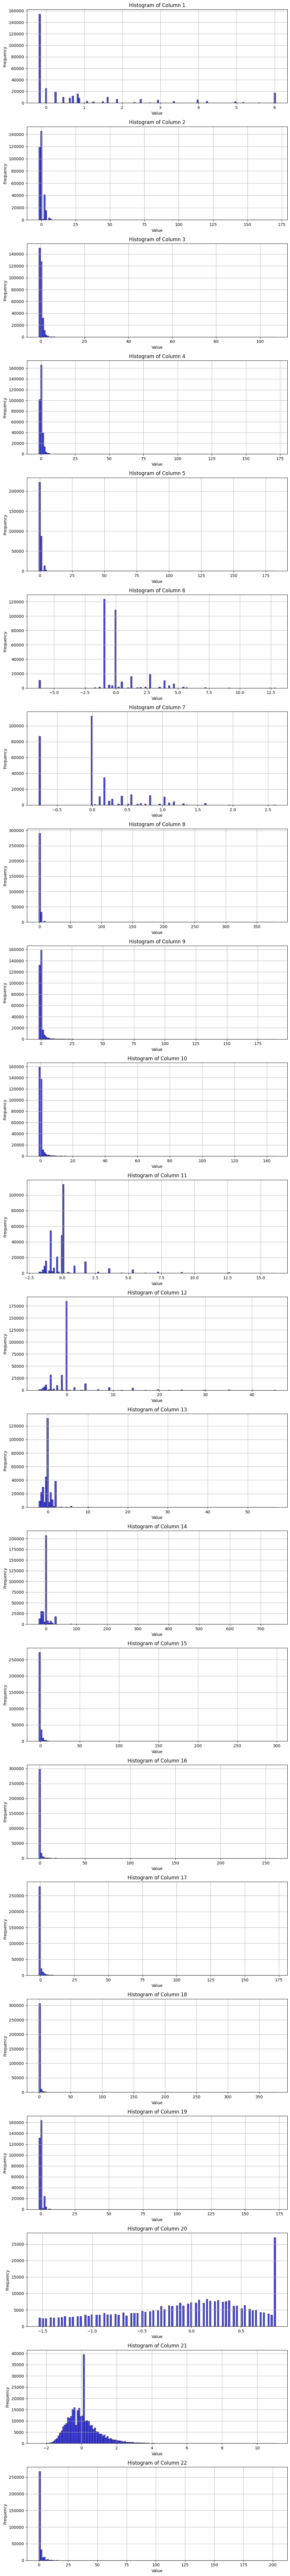

In [52]:
import numpy as np
import matplotlib.pyplot as plt 

# Determine the number of columns
num_columns = x_train_copy.shape[1]

# Create subplots for each column's histogram
fig, axes = plt.subplots(num_columns, 1, figsize=(10, 4 * num_columns))

for i in range(num_columns):
    axes[i].hist(x_train_copy[:, i], bins=150, alpha=0.7, color='blue', edgecolor='black')
    axes[i].set_title(f'Histogram of Column {i + 1}')
    axes[i].set_xlabel('Value')
    axes[i].set_ylabel('Frequency')
    axes[i].grid(True)

plt.tight_layout()
plt.show()

# Ridge

In [53]:
SEED = 42
PREDICTION_METHOD = "ridge_gd"  # Prediction method (see training_function.py for options)
LABDA_REGULARIZATION = 0.1  # Regularization parameter for Lasso or Ridge regression
GAMMA_OPTIMIZER = 0.01  # Learning rate during optimization methods
INITIAL_W = "zeros"  # Method to initialize weights in GD or logistic regression (see training_function.py for options)
MAX_ITERS = 50 #  max iters in optimization method
K_FOLDS = 10 # Number of folds in stratified corss validation

mean_accuracies = []
mean_f1_scores = []
lambdas = np.logspace(-3, 8,25)
BEST_f1_score_ridge = 0 #the one of the best model

for i,lambda_ridge in enumerate(lambdas):
    # Perform stratified k-fold cross-validation
    fold_metrics, \
    best_w, \
    best_accuracy, \
    best_f1_score, \
    best_confusion_matrix, \
    mean_val_accuracy, \
    mean_val_f1_score, \
    mean_train_accuracy, \
    mean_train_f1_score = stratified_k_fold_cross_validation(
        y = y_train,  # Labels for the dataset
        tx = x_train_copy,  # Feature matrix
        k_folds = K_FOLDS,  # Number of folds for cross-validation
        max_iters = MAX_ITERS,  # Maximum iterations for optimization
        gamma = GAMMA_OPTIMIZER,  # Learning rate for optimization
        lambda_regularization = lambda_ridge,  # Regularization parameter
        prediction_method = PREDICTION_METHOD ,  # Method used for optimization
        initialization_w = INITIAL_W,  # Weight initialization method
        seed=SEED,  # Seed for reproducibility
    )

    if mean_val_f1_score > BEST_f1_score_ridge:
        best_model_ridge = best_w
        best_lambda_ridge = lambda_ridge
        BEST_f1_score_ridge = mean_val_f1_score 

    
    mean_accuracies.append(mean_val_accuracy)
    mean_f1_scores.append(mean_val_f1_score)
    print(f"\t\t ---> {i}")

print(f"Best model F1 {BEST_f1_score_ridge}")


Fold 1/10: Validation Loss=0.19467296103523568, Accuracy=0.9024501737063448, F1=0.019000919399325775
Fold 1/10: Training Loss=0.19389332285249006, Accuracy=0.9010771330179703, F1=0.02156875879161364


Fold 2/10: Validation Loss=0.19621148022469354, Accuracy=0.900926433839215, F1=0.024016811768237768
Fold 2/10: Training Loss=0.1937502866745141, Accuracy=0.9012024204171054, F1=0.02113597477102694


Fold 3/10: Validation Loss=0.1944968688451449, Accuracy=0.9011702322179558, F1=0.017570433202059983
Fold 3/10: Training Loss=0.193910885886927, Accuracy=0.9011753312497248, F1=0.02178649237472767


Fold 4/10: Validation Loss=0.19586372496485582, Accuracy=0.8999512403242519, F1=0.023207378756322526
Fold 4/10: Training Loss=0.1937785399015887, Accuracy=0.9012498264600215, F1=0.021145906756620685


Fold 5/10: Validation Loss=0.19272516210221596, Accuracy=0.9017187785701225, F1=0.026562028373075763
Fold 5/10: Training Loss=0.1941077702112795, Accuracy=0.9011076083312735, F1=0.020787929589270747




## Plot

[np.float64(0.9011717727216082), np.float64(0.9011717727216082), np.float64(0.9011717727216082), np.float64(0.9011717727216082), np.float64(0.9011717727216082), np.float64(0.9011717727216082), np.float64(0.9011748202013425), np.float64(0.901177867773951), np.float64(0.9011839628262936), np.float64(0.9012083431285387), np.float64(0.9012692936519653), np.float64(0.9015130957456725), np.float64(0.9021317441621359), np.float64(0.9033050429919026), np.float64(0.8974842629894415), np.float64(0.8493973475783271), np.float64(0.8029439125104927), np.float64(0.7763085282934185), np.float64(0.7613604206423655), np.float64(0.7435506886562135), np.float64(0.7192314334310238), np.float64(0.7014216829629143), np.float64(0.6931720271559356), np.float64(0.6864491769920301), np.float64(0.6766635653013462)]
[np.float64(0.021363230299329464), np.float64(0.021363230299329464), np.float64(0.021363230299329464), np.float64(0.021363230299329464), np.float64(0.021363230299329464), np.float64(0.0213632302993294

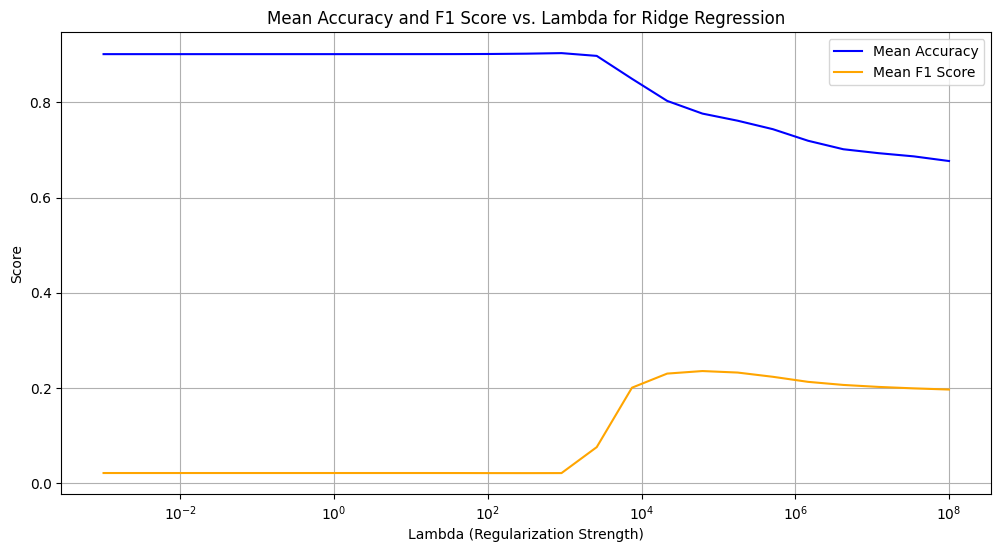

In [54]:
print(mean_accuracies)
print(mean_f1_scores)
import matplotlib.pyplot as plt
# Plotting
plt.figure(figsize=(12, 6))
plt.plot(lambdas, mean_accuracies, label='Mean Accuracy', color='blue')
plt.plot(lambdas, mean_f1_scores, label='Mean F1 Score', color='orange')

plt.xscale('log')  # Log scale for lambda
plt.xlabel('Lambda (Regularization Strength)')
plt.ylabel('Score')
plt.title('Mean Accuracy and F1 Score vs. Lambda for Ridge Regression')
plt.legend()
plt.grid()
plt.show()

## Prediction

In [56]:
test_predictions_ridge = np.sign(np.dot(x_test_preprocessed, best_model_ridge)) # ATTENTION: +1, -1

create_csv_submission(test_ids, test_predictions_ridge, "prediction_ridge.csv")

# Least Squares

In [57]:
PREDICTION_METHOD = "least_squares"  # Prediction method (see training_function.py for options)

#LEAST SQUARES
fold_metrics, \
best_w, \
best_accuracy, \
best_f1_score, \
best_confusion_matrix, \
mean_val_accuracy, \
mean_val_f1_score, \
mean_train_accuracy, \
mean_train_f1_score = stratified_k_fold_cross_validation(
    y = y_train,  # Labels for the dataset
    tx = x_train_copy,  # Feature matrix
    k_folds = K_FOLDS,  # Number of folds for cross-validation
    max_iters = MAX_ITERS,  # Maximum iterations for optimization
    gamma = GAMMA_OPTIMIZER,  # Learning rate for optimization
    lambda_regularization = lambda_ridge,  # Regularization parameter
    prediction_method = PREDICTION_METHOD ,  # Method used for optimization
    initialization_w = INITIAL_W,  # Weight initialization method
    seed=SEED,  # Seed for reproducibility
)

print(best_accuracy, best_f1_score)

Fold 1/10: Validation Loss=0.1946729599859638, Accuracy=0.9024501737063448, F1=0.019000919399325775
Fold 1/10: Training Loss=0.19389332285245162, Accuracy=0.9010771330179703, F1=0.02156875879161364


Fold 2/10: Validation Loss=0.19621147594803573, Accuracy=0.900926433839215, F1=0.024016811768237768
Fold 2/10: Training Loss=0.1937502866744756, Accuracy=0.9012024204171054, F1=0.02113597477102694


Fold 3/10: Validation Loss=0.19449687033250113, Accuracy=0.9011702322179558, F1=0.017570433202059983
Fold 3/10: Training Loss=0.19391088588688865, Accuracy=0.9011753312497248, F1=0.02178649237472767


Fold 4/10: Validation Loss=0.1958637258568164, Accuracy=0.8999512403242519, F1=0.023207378756322526
Fold 4/10: Training Loss=0.19377853990154986, Accuracy=0.9012498264600215, F1=0.021145906756620685


Fold 5/10: Validation Loss=0.1927251623098982, Accuracy=0.9017187785701225, F1=0.026562028373075763
Fold 5/10: Training Loss=0.19410777021124118, Accuracy=0.9011076083312735, F1=0.020787929589270747


# Logistic regression

In [ ]:
# tranform labels to 0,1 
x_train_prepocessed = x_train_copy
y_train_lg = np.where(y_train == -1, 0, y_train)

In [ ]:
# RMEMBER TO PUT THE LABELS BACK TO -1 1 FOR GRADING